In [14]:
# --- Chunk 1: Load posts and NRC-VAD (robust) ---

import pandas as pd
import numpy as np
import re
from pathlib import Path
import matplotlib.pyplot as plt

base_dir = Path('.').resolve()
data_dir = base_dir / 'dataset'

# Your predictions CSV from the MentalBERT inference step
posts = pd.read_csv(data_dir / 'beyondb_post_predictions.csv')

# NRC VAD 2.1 uses tab-separated columns; values are already in [0,1]
lex = pd.read_csv(data_dir / 'NRC-VAD-Lexicon-v2.1.txt', sep='\t')

# Normalize/clean term field
lex['term_clean'] = lex['term'].astype(str).str.lower()

# Keep single-word entries (VAD is mostly unigrams anyway)
lex_single = lex[~lex['term_clean'].str.contains(' ', na=False)].copy()

# Build lookup (float) for fast access
vad_lookup = lex_single.set_index('term_clean')[['valence','arousal','dominance']].astype(float).to_dict('index')

# Tokenizer for simple word tokens (keeps apostrophes)
pattern = re.compile(r"[a-z']+")


In [15]:
# --- Chunk 2: Compute VAD means + coverage per post ---

def compute_vad(text: str):
    if not isinstance(text, str) or not text.strip():
        return np.nan, np.nan, np.nan, 0
    tokens = pattern.findall(text.lower())
    scored = [vad_lookup[t] for t in tokens if t in vad_lookup]
    if not scored:
        return np.nan, np.nan, np.nan, 0
    arr = np.array([[s['valence'], s['arousal'], s['dominance']] for s in scored], dtype=float)
    v, a, d = arr.mean(axis=0)
    return v, a, d, len(scored)

vad_vals = posts['cleaned_post_content'].apply(compute_vad)
posts[['valence','arousal','dominance','vad_hits']] = pd.DataFrame(vad_vals.tolist(), index=posts.index)

# Optional (but helpful): inspect coverage
# print(posts['vad_hits'].describe())


In [16]:
# --- Chunk 3: Build a severity score with correct scaling ---

# Global means (for NaN fill when a post has no VAD hits)
v_mean = posts['valence'].mean()
a_mean = posts['arousal'].mean()
d_mean = posts['dominance'].mean()

# Heuristic: negative valence (1 - v), high arousal (a), low dominance (1 - d)
base_score = ((1 - posts['valence'].fillna(v_mean)) * 0.5
              + posts['arousal'].fillna(a_mean) * 0.3
              + (1 - posts['dominance'].fillna(d_mean)) * 0.2)

# If an item has extremely low lexicon coverage, you can optionally de-emphasize it:
# e.g., shrink toward corpus mean for posts with very few hits.
# Uncomment if desired:
# cov = posts['vad_hits'].fillna(0).clip(0, 10) / 10.0   # 0..1
# base_score = cov * base_score + (1 - cov) * base_score.mean()

# Min-max normalize to [0,1] for comparability
score_min = float(base_score.min())
score_max = float(base_score.max())
if score_max - score_min == 0:
    posts['severity_score'] = 0.5
else:
    posts['severity_score'] = (base_score - score_min) / (score_max - score_min)

# Data-driven cut points (adjust as needed)
q_mild = posts['severity_score'].quantile(0.40)
q_severe = posts['severity_score'].quantile(0.75)

def assign_severity(score):
    if pd.isna(score):
        return 'moderate'  # safe default when no signal
    if score >= q_severe:
        return 'severe'
    if score >= q_mild:
        return 'moderate'
    return 'mild'

posts['pred_severity'] = posts['severity_score'].apply(assign_severity)


In [18]:
# --- Chunk 4: Build concise reasons using lowest-valence terms ---

def build_reason(row):
    text = row['cleaned_post_content']
    if not isinstance(text, str) or not text.strip():
        return 'Insufficient text for analysis.'

    tokens = pattern.findall(text.lower())
    scored = [(tok, vad_lookup[tok]['valence']) for tok in tokens if tok in vad_lookup]
    if not scored:
        # Mention coverage explicitly
        return f"Low lexicon coverage (vad_hits={int(row.get('vad_hits',0))}); metrics may rely on corpus means."

    scored.sort(key=lambda x: x[1])  # lowest valence first
    key_terms = [tok for tok, _ in scored[:3]]

    # ✅ Simplified reason: only lowest-valence terms
    if key_terms:
        return f"Lowest-valence terms: {', '.join(key_terms)}"
    else:
        return "No low-valence terms detected."


Unique pred_severity values: ['mild' 'severe' 'moderate']
Saved to /home/chahar/mentalBert/project_B/dataset/severity_pred_VAD.csv
pred_severity
mild        5105
moderate    4467
severe      3191
Name: count, dtype: int64


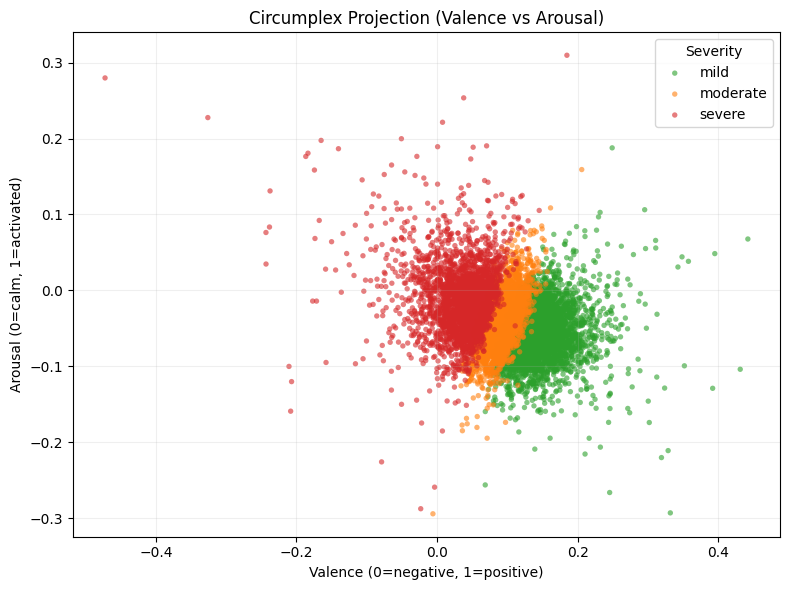

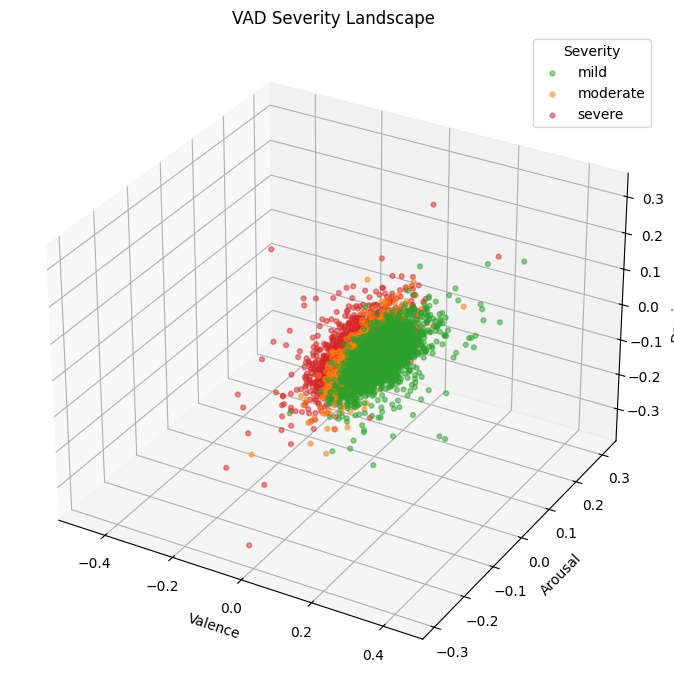

In [20]:
# --- Chunk 5: Visualize & save (robust) ---

import numpy as np
import matplotlib.pyplot as plt

# 0) Coerce VAD columns to numeric (in case they became object/string)
for col in ["valence", "arousal", "dominance"]:
    if col in posts.columns:
        posts[col] = pd.to_numeric(posts[col], errors="coerce")

# 1) Guard against unexpected severity labels / NaNs
colors = {"severe": "#d62728", "moderate": "#ff7f0e", "mild": "#2ca02c"}
valid_sev = set(colors.keys())
if "pred_severity" not in posts.columns:
    raise ValueError("pred_severity column not found. Did the scoring step run?")

print("Unique pred_severity values:", posts["pred_severity"].unique())

plot_df = posts[posts["pred_severity"].isin(valid_sev)].copy()
# Drop rows with missing coordinates
plot_df = plot_df.dropna(subset=["valence", "arousal"])

# 2D circumplex
fig, ax = plt.subplots(figsize=(8, 6))
for sev, grp in plot_df.groupby("pred_severity"):
    if grp.empty:
        continue
    ax.scatter(
        grp["valence"].values, grp["arousal"].values,
        s=15, c=colors.get(sev, "#888888"), label=sev, alpha=0.6, edgecolors="none"
    )

ax.set_xlabel("Valence (0=negative, 1=positive)")
ax.set_ylabel("Arousal (0=calm, 1=activated)")
ax.set_title("Circumplex Projection (Valence vs Arousal)")
if not plot_df.empty:
    ax.legend(title="Severity")
ax.grid(alpha=0.2)
plt.tight_layout()

# 3D (optional)
try:
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    fig = plt.figure(figsize=(9, 7))
    ax3 = fig.add_subplot(111, projection="3d")

    plot3d = plot_df.dropna(subset=["dominance"]).copy()
    for sev, grp in plot3d.groupby("pred_severity"):
        if grp.empty:
            continue
        ax3.scatter(
            grp["valence"].values, grp["arousal"].values, grp["dominance"].values,
            s=12, c=colors.get(sev, "#888888"), label=sev, alpha=0.5
        )
    ax3.set_xlabel("Valence")
    ax3.set_ylabel("Arousal")
    ax3.set_zlabel("Dominance")
    ax3.set_title("VAD Severity Landscape")
    if not plot3d.empty:
        ax3.legend(title="Severity")
    plt.tight_layout()
except Exception as e:
    print("3D plot skipped due to error:", repr(e))

# 4) Save a clean, analysis-friendly CSV (only include columns that exist)
ordered_columns = [
    "forum_name","thread_id","cleaned_post_content",
    "pred_emotions","pred_probabilities",
    "valence","arousal","dominance","vad_hits",
    "severity_score","pred_severity","severity_reason"
]
existing_cols = [c for c in ordered_columns if c in posts.columns]
out_path = data_dir / "severity_pred_VAD.csv"
posts[existing_cols].to_csv(out_path, index=False)
print("Saved to", out_path)

# Also show a quick count safely
if "pred_severity" in posts.columns:
    print(posts["pred_severity"].value_counts(dropna=False))


In [22]:
# Show the first 10 rows of the key output columns
pd.set_option("display.max_colwidth", 180)
print(posts[existing_cols].head(1))


  forum_name  thread_id  \
0    anxiety     610659   

                                                                                                                                                                  cleaned_post_content  \
0  hi my name is michelle and i have had anxiety my whole life. usually i have been able to control it but lately it is getting worse i have seen a doctor and been given more medi...   

  pred_emotions  \
0          fear   

                                                                                                                          pred_probabilities  \
0  {"anger": 0.036796, "disgust": 0.010219, "fear": 0.341005, "joy": 0.175706, "sadness": 0.062474, "surprise": 0.33252, "neutral": 0.04128}   

    valence   arousal  dominance  vad_hits  severity_score pred_severity  
0  0.164016 -0.065098   0.028426        61        0.294483          mild  
